# Preliminaries

In [1]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import *


plt.rc('font', size=12)
warnings.filterwarnings('ignore')

In [2]:
#Load ESCAPE training data
escapeAllData = pd.read_csv("Data/Original DataFrames/AllDataSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #all feature dataset
escapeHemo = pd.read_csv("Data/Original DataFrames/HemoSingleValue.csv", sep=",", index_col='DEIDNUM').sort_index() #dataset with only hemodynamics
escapeLabels  = pd.read_csv("Data/Original DataFrames/Labels.csv", sep=",", index_col='DEIDNUM').sort_index() #labels for prediction classes 

#Load validation ####TODO - FIX LABELS HERE
#Aric cohort
aricCohortHemo = pd.read_csv("Data Validation/ARIC/Original DataFrames/HemoAricCohort.csv", sep=",", index_col='ID').sort_index()
aricCohortAllData = pd.read_csv("Data Validation/ARIC/Original DataFrames/AllDataAricCohort.csv", sep=",", index_col='ID').sort_index()
cohortHemoLabels = pd.read_csv("Data Validation/ARIC/Original DataFrames/HemoLabelsAricCohort.csv", sep=",", index_col='ID').sort_index()
cohortLabels = pd.read_csv("Data Validation/ARIC/Original DataFrames/LabelsAricCohort.csv", sep=",", index_col='ID').sort_index()

#aric comm
aricCommHemo = pd.read_csv("Data Validation/ARIC/Original DataFrames/HemoAricComm.csv", sep=",", index_col='ID').sort_index()
aricCommAllData = pd.read_csv("Data Validation/ARIC/Original DataFrames/AllDataAricComm.csv", sep=",", index_col='ID').sort_index()
commHemoLabels = pd.read_csv("Data Validation/ARIC/Original DataFrames/HemoLabelsAricComm.csv", sep=",", index_col='ID').sort_index()
commLabels = pd.read_csv("Data Validation/ARIC/Original DataFrames/LabelsAricComm.csv", sep=",", index_col='ID').sort_index()

#Guide it
guideAllData = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/AllDataGUIDE-IT.csv", sep=",", index_col='ID').sort_index()
guideLabels = pd.read_csv("Data Validation/GUIDE-IT/Original DataFrames/LabelsGUIDE-IT.csv", sep=",", index_col='ID').sort_index()


In [3]:
#Fix missing labels
cohortHemoLabels['Rehosp'] = 0
cohortHemoLabels['Readmission'] = 0
cohortLabels['Rehosp'] = 0
cohortLabels['Readmission'] = 0

commHemoLabels['Rehosp'] = 0
commHemoLabels['Readmission'] = 0
commLabels['Rehosp'] = 0
commLabels['Readmission'] = 0

guideLabels['Readmission'] = 0

# Cluster Labels

In [4]:
#HELPER METHODS

def plotPCAClusters(X, y_km, K, name): #plot clusters from pca
    df = pd.DataFrame(X, columns=["Component_1", "Component_2"])
    df['Cluster'] = y_km + 1
    plt.figure(figsize=(16,7))
    sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', palette=sns.color_palette('hls', K), data=df, legend='full')
    plt.title("Resulting Score Clusters")
    plt.savefig("Score Label Preprocessing/Figures/Score_Clusters_" + name + ".png")

    plt.show()
    
    return X

def plotClusters(X, y_km, columns, K): #plot original data clusters
    X['cluster'] = y_km
    plt.figure(figsize=(16,7))
    sns.scatterplot(x=columns[0], y=columns[1], hue='cluster',palette=sns.color_palette('hls', K), data=X, legend='full')
    plt.show()
    
    return X

def compareClusters(dt, K): #compare details of clusters
    clusters = []
    clusterDesc = []
    for num in range(K):
        cls = dt[dt['cluster'] == num]
        clusters.append(cls)

#         print("Cluster ", num)
#         print(cls.describe())
        clusterDesc.append(cls.describe())
        
    return clusters, clusterDesc

def runClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    y_model = clusterModel.fit_predict(data)

    #Save cluster model
    pickle.dump(clusterModel, open('Score Label Preprocessing/ClusterModels/' + modelName + '.sav', 'wb'))
    
    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary

def runValidationClustering(clusterModel, data, origData, labels, modelName, columns, pca=False):
    #Run clustering
    if fitPredFlag:
        y_model = clusterModel.fit_predict(data)
    else:
        y_model = clusterModel.predict(data)

    #Plot Clusters
    if not pca:
        plotClusters(origData, y_model, columns, 5)
    else:
        plotPCAClusters(data, y_model, 5, modelName)
    
    #Get real data with clusters
    DF = copy.deepcopy(origData)
    DF['cluster'] = y_model

    #add class labels
    DF['Death'] = labels['Death']
    DF['Rehosp'] = labels['Rehosp']
    DF['Readmission'] = labels['Readmission']

    #get descriptions of each cluster
    clusters, clusterDesc = compareClusters(DF, 5)
    
    #get descriptive summary details for each cluster
    descSummary = pd.DataFrame()
    for i in range(len(clusterDesc)):
        descSummary = descSummary.append(clusterDesc[i])
    
    return DF, descSummary

def assignScoresFromClusters(descSummary):
    clsScDF = pd.DataFrame()
    clsScDF.index.name = 'Cluster'

    scores = [1,2,3,4,5]
    dthMn = descSummary.loc['mean']['Death'].to_numpy()
    rehospMn = descSummary.loc['mean']['Rehosp'].to_numpy()
    readmMn = descSummary.loc['mean']['Readmission'].to_numpy()
    
    dthScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(dthMn):
        dthScores[v] = scores[cnt]
        cnt += 1

    rehospScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(rehospMn):
        rehospScores[v] = scores[cnt]
        cnt += 1

    readmScores = [0,0,0,0,0]
    cnt = 0
    for v in np.argsort(readmMn):
        readmScores[v] = scores[cnt]
        cnt += 1

    clsScDF['DeathMean'] = dthMn
    clsScDF['DeathScores'] = dthScores
    clsScDF['RehospMean'] = rehospMn
    clsScDF['RehospScores'] = rehospScores
    clsScDF['ReadmMean'] = readmMn
    clsScDF['ReadmScores'] = readmScores

    aveScores = []
    for i in clsScDF.index:
        c = clsScDF.loc[i]
        a = c['DeathScores'] + c['RehospScores'] + c['ReadmScores']
        aveScores.append(a/3)

    clsScDF['AveScores'] = aveScores
    
    rankIndex = sorted(range(len(aveScores)), key = lambda sub: aveScores[sub], reverse=True)[:5] 
    print("rank index", rankIndex)
    finalScores = [0,0,0,0,0]
    val = 5
    for r in rankIndex:
        finalScores[int(r)] = val
        val -= 1
    
    return clsScDF, finalScores
    

def saveClusteredData(hemoDF, scoreAsmts, saveName):
    
    clusNums = hemoDF['cluster']

    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['FinalScores']))
    hemoDF['Score'] = labels

    #Death Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['DeathScores']))
    hemoDF['ScoreDeath'] = labels

    #Rehosp Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['RehospScores']))

    hemoDF['ScoreRehosp'] = labels

    #Readm Scores
    labels = []
    for c in clusNums:
        labels.append(int(scoreAsmts.loc[c]['ReadmScores']))
    hemoDF['ScoreReadmission'] = labels

    hemoDF = hemoDF.drop(columns=["cluster"])
    hemoDF = hemoDF.drop(columns=["Death"])
    hemoDF = hemoDF.drop(columns=["Rehosp"])
    hemoDF = hemoDF.drop(columns=["Readmission"])

    hemoDF.to_csv(saveName)
    
    return hemoDF

In [5]:
# Global Flags
pcaFlag = True
fitPredFlag = False

# Choose clutering model
# ac = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
clusterModel = KMeans(n_clusters=5)
# ac = SpectralClustering(n_clusters=5, assign_labels='discretize')

hemoModelName = 'Cluster_AC_Hemo'
allDataModelName = 'Cluster_AC_AllData'

# HEMO

# Cluster: ESCAPE Hemo

In [6]:
# first - try other clustering methods
hemo = copy.deepcopy(escapeHemo)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

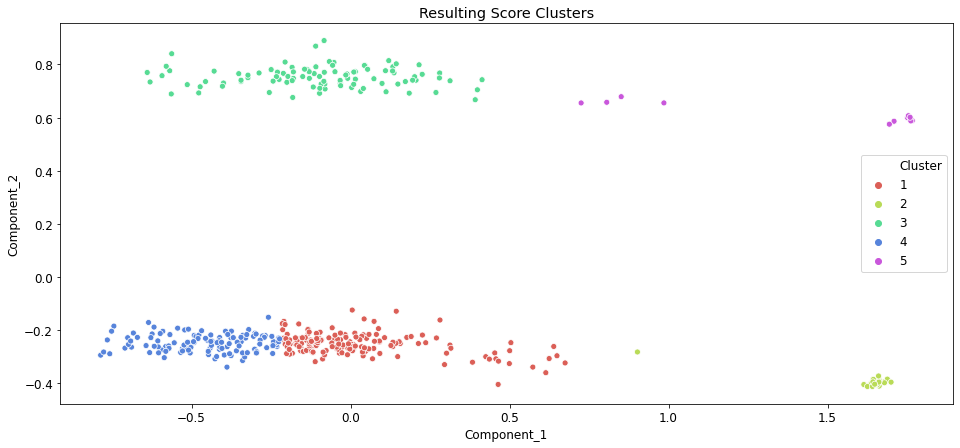

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,cluster,Death,Rehosp,Readmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,2,1,1,0
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,2,1,1,0
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,0,0,1,0
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,0,0,1,0
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,1,0,0,0
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,3,1,1,0
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,3,1,1,0


In [7]:
hemoDF, descSummary = runClustering(clusterModel=clusterModel, data=data, origData=escapeHemo, labels=escapeLabels, 
                                    modelName=hemoModelName, columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
hemoDF

In [8]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [3, 0, 1, 4, 2]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.302469,2,0.586420,5,0.166667,3,3.333333
1,0.384615,4,0.423077,1,0.230769,5,3.333333
2,0.257732,1,0.546392,3,0.144330,1,1.666667
3,0.325000,3,0.566667,4,0.175000,4,3.666667
4,0.384615,5,0.538462,2,0.153846,2,3.000000


In [9]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[4, 3, 1, 5, 2]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.302469,2,0.586420,5,0.166667,3,3.333333,4
1,0.384615,4,0.423077,1,0.230769,5,3.333333,3
2,0.257732,1,0.546392,3,0.144330,1,1.666667,1
3,0.325000,3,0.566667,4,0.175000,4,3.666667,5
4,0.384615,5,0.538462,2,0.153846,2,3.000000,2


In [10]:
hemoDF = saveClusteredData(hemoDF, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AC_Hemo.csv")
hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,25.0,24.0,42.0,24.0,30.0,36.0,2.20,...,0.666667,0.266667,0.750000,0.777778,50.0,1.166667,1,1,3,1
72,88.0,2.0,1.0,25.0,18.0,42.0,24.0,30.0,24.0,3.10,...,0.750000,0.272727,1.000000,1.000000,50.0,1.333333,1,1,3,1
81,69.0,1.0,1.0,20.0,10.0,40.0,20.0,27.0,18.0,4.52,...,0.555556,0.242857,2.000000,0.944444,45.0,1.700000,4,2,5,3
81,69.0,1.0,1.0,20.0,12.0,35.0,15.0,25.0,17.0,4.65,...,0.705882,0.571429,1.666667,2.352941,45.0,3.333333,4,2,5,3
814,58.0,1.0,1.0,NaN,3.0,51.0,19.0,30.0,18.0,4.10,...,0.166667,0.566667,10.666667,1.888889,44.0,11.333333,4,2,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98508,57.0,1.0,98.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.0,NaN,3,4,1,5
99302,41.0,1.0,2.0,15.0,19.0,87.0,37.0,54.0,44.0,3.90,...,0.431818,0.642857,2.631579,1.227273,13.0,2.842105,5,3,4,4
99302,41.0,1.0,2.0,15.0,11.0,70.0,28.0,44.0,28.0,5.30,...,0.392857,1.088608,3.818182,3.071429,13.0,7.818182,5,3,4,4


# Cluster: ARIC Cohort Hemo

In [11]:
# first - try other clustering methods
hemo = copy.deepcopy(aricCohortHemo)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

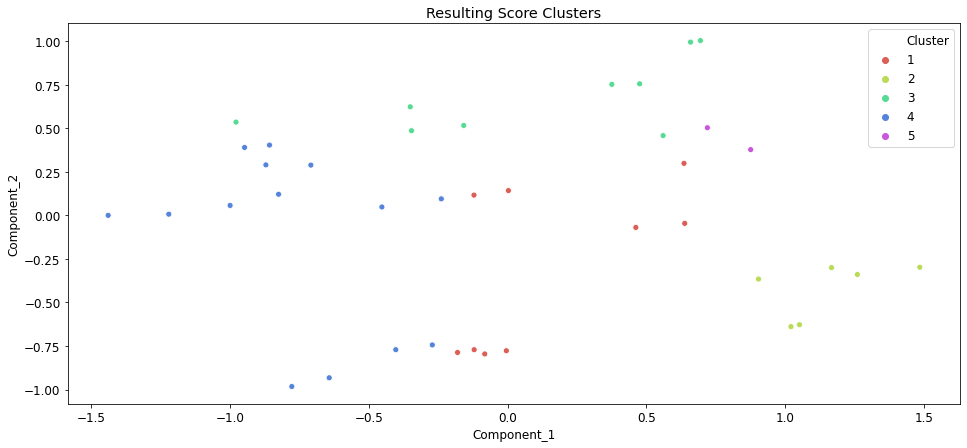

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.794118,0,2.347826,39.0,2.160000,0,0,0,0
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.735294,0,2.173913,33.0,2.000000,0,0,0,0
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.210526,0,5.750000,51.0,8.625000,3,0,0,0
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.456140,0,6.916667,63.0,10.375000,3,0,0,0
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.466667,0,1.680000,46.0,2.800000,3,1,0,0
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.288889,0,1.040000,29.0,1.733333,3,1,0,0
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.520408,0,25.500000,90.0,-25.500000,2,0,0,0
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.551020,0,27.000000,92.0,-27.000000,2,0,0,0
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,NaN,0.604167,0,3.866667,37.0,NaN,2,1,0,0


In [12]:
model = pickle.load(open('Score Label Preprocessing/ClusterModels/'+ hemoModelName + '.sav', 'rb'))

hemoDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=aricCohortHemo, labels=cohortHemoLabels, 
                                    modelName='AricCohortHemo', columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
hemoDF

In [13]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [3, 4, 2, 1, 0]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.000000,1,0.0,1,0.0,1,1.000000
1,0.000000,2,0.0,2,0.0,2,2.000000
2,0.222222,4,0.0,3,0.0,3,3.333333
3,0.571429,5,0.0,4,0.0,4,4.333333
4,0.000000,3,0.0,5,0.0,5,4.333333


In [14]:
print(finalScores)
scoreAsmts['FinalScores'] = scoreAsmts['DeathScores']
scoreAsmts

[1, 2, 3, 5, 4]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.000000,1,0.0,1,0.0,1,1.000000,1
1,0.000000,2,0.0,2,0.0,2,2.000000,2
2,0.222222,4,0.0,3,0.0,3,3.333333,4
3,0.571429,5,0.0,4,0.0,4,4.333333,5
4,0.000000,3,0.0,5,0.0,5,4.333333,3


In [15]:
hemoDF = saveClusteredData(hemoDF, scoreAsmts,"Data Validation/ARIC/Preprocessed Data/Aric_Cohort_AC_Hemo.csv")
hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.794118,0,2.347826,39.0,2.160000,1,1,1,1
S110616,74,2,1,25.0,25.0,64.0,0,0,23.0,2.50,...,1.086957,0.735294,0,2.173913,33.0,2.000000,1,1,1,1
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.210526,0,5.750000,51.0,8.625000,5,5,4,4
S112447,66,2,1,60.0,8.0,110.0,0,0,12.0,NaN,...,0.666667,1.456140,0,6.916667,63.0,10.375000,5,5,4,4
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.466667,0,1.680000,46.0,2.800000,5,5,4,4
S113841,79,1,1,NaN,15.0,45.0,0,0,25.0,4.40,...,0.600000,0.288889,0,1.040000,29.0,1.733333,5,5,4,4
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.520408,0,25.500000,90.0,-25.500000,4,4,3,3
S114430,71,1,2,10.0,-2.0,17.0,0,0,2.0,4.00,...,-1.000000,0.551020,0,27.000000,92.0,-27.000000,4,4,3,3
S116317,74,1,2,45.0,NaN,NaN,0,0,15.0,NaN,...,NaN,0.604167,0,3.866667,37.0,NaN,4,4,3,3


# Cluster: ARIC Comm Hemo

In [16]:
# first - try other clustering methods
hemo = copy.deepcopy(aricCommHemo)
hemo = hemo.replace(np.inf, 0)
hemo = hemo.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    hemo.loc[:,:] = scaler.fit_transform(hemo)
    pca = PCA(n_components=2)
    data = pca.fit_transform(hemo)
else:
    data=hemo

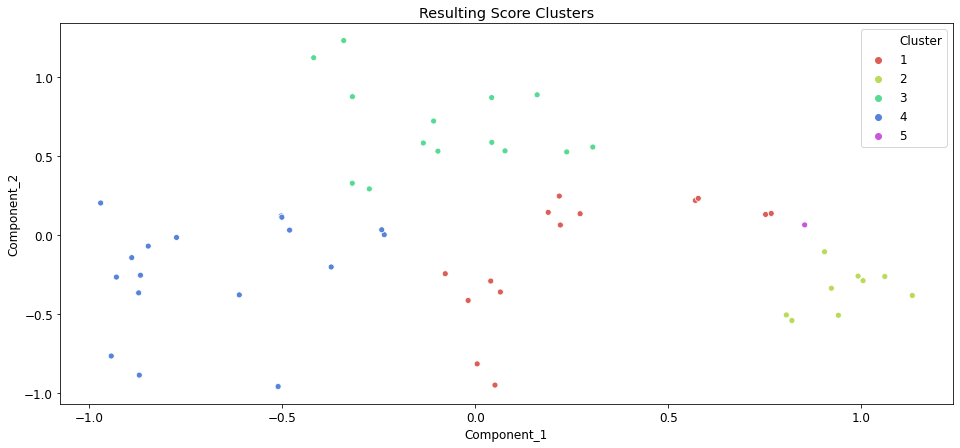

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
S113719,55,1,0,10.0,23.0,29.0,0,0,20.0,NaN,...,1.150000,0.224490,0,1.100000,58.0,0.956522,0,0,0,0
S113719,55,1,0,10.0,23.0,29.0,0,0,20.0,NaN,...,1.150000,0.500000,0,2.450000,56.0,2.130435,0,0,0,0
S114046,61,1,0,NaN,14.0,35.0,0,0,16.0,3.8,...,0.875000,0.097744,0,0.812500,42.0,0.928571,0,0,0,0
S114046,61,1,0,NaN,14.0,35.0,0,0,16.0,3.8,...,0.875000,0.135338,0,1.125000,29.0,1.285714,0,0,0,0
S115069,60,1,0,NaN,3.0,23.0,0,0,3.0,3.3,...,1.000000,1.262136,0,43.333333,37.0,43.333333,2,0,0,0
S115069,60,1,0,NaN,3.0,23.0,0,0,3.0,3.3,...,1.000000,0.368932,0,12.666667,64.0,12.666667,2,0,0,0
S115472,60,1,0,55.0,3.0,43.0,0,0,24.0,7.7,...,0.125000,1.333333,0,4.500000,66.0,36.000000,2,0,0,0
S115472,60,1,0,55.0,3.0,43.0,0,0,24.0,7.7,...,0.125000,1.160494,0,3.916667,46.0,31.333333,2,0,0,0
S117776,83,2,0,NaN,6.0,26.0,0,0,13.0,3.5,...,0.461538,0.283186,0,2.461538,79.0,5.333333,3,0,0,0


In [17]:
model = pickle.load(open('Score Label Preprocessing/ClusterModels/'+ hemoModelName + '.sav', 'rb'))

hemoDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=aricCommHemo, labels=commHemoLabels, 
                                    modelName='AricCommHemo', columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
hemoDF.head(10)

In [18]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [4, 3, 2, 1, 0]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.0,1,0.0,1,0.0,1,1.0
1,0.0,2,0.0,2,0.0,2,2.0
2,0.0,3,0.0,3,0.0,3,3.0
3,0.0,4,0.0,4,0.0,4,4.0
4,0.0,5,0.0,5,0.0,5,5.0


In [19]:
print(finalScores)
scoreAsmts['FinalScores'] = scoreAsmts['DeathScores']
scoreAsmts

[1, 2, 3, 4, 5]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.0,1,0.0,1,0.0,1,1.0,1
1,0.0,2,0.0,2,0.0,2,2.0,2
2,0.0,3,0.0,3,0.0,3,3.0,3
3,0.0,4,0.0,4,0.0,4,4.0,4
4,0.0,5,0.0,5,0.0,5,5.0,5


In [20]:
hemoDF = saveClusteredData(hemoDF, scoreAsmts,"Data Validation/ARIC/Preprocessed Data/Aric_Comm_AC_Hemo.csv")
hemoDF

,Age,Gender,Race,EjF,RAP,PAS,PAD,PAMN,PCWP,CO,...,RAT,PPRatio,PAPi,SAPi,CPP,PRAPRat,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
S113719,55,1,0,10.0,23.0,29.0,0,0,20.0,NaN,...,1.150000,0.224490,0,1.100000,58.0,0.956522,1,1,1,1
S113719,55,1,0,10.0,23.0,29.0,0,0,20.0,NaN,...,1.150000,0.500000,0,2.450000,56.0,2.130435,1,1,1,1
S114046,61,1,0,NaN,14.0,35.0,0,0,16.0,3.80,...,0.875000,0.097744,0,0.812500,42.0,0.928571,1,1,1,1
S114046,61,1,0,NaN,14.0,35.0,0,0,16.0,3.80,...,0.875000,0.135338,0,1.125000,29.0,1.285714,1,1,1,1
S115069,60,1,0,NaN,3.0,23.0,0,0,3.0,3.30,...,1.000000,1.262136,0,43.333333,37.0,43.333333,3,3,3,3
S115069,60,1,0,NaN,3.0,23.0,0,0,3.0,3.30,...,1.000000,0.368932,0,12.666667,64.0,12.666667,3,3,3,3
S115472,60,1,0,55.0,3.0,43.0,0,0,24.0,7.70,...,0.125000,1.333333,0,4.500000,66.0,36.000000,3,3,3,3
S115472,60,1,0,55.0,3.0,43.0,0,0,24.0,7.70,...,0.125000,1.160494,0,3.916667,46.0,31.333333,3,3,3,3
S117776,83,2,0,NaN,6.0,26.0,0,0,13.0,3.50,...,0.461538,0.283186,0,2.461538,79.0,5.333333,4,4,4,4


# ALL DATA

# Cluster: ESCAPE All Data

In [21]:
# first - try other clustering methods
allD = copy.deepcopy(escapeAllData)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

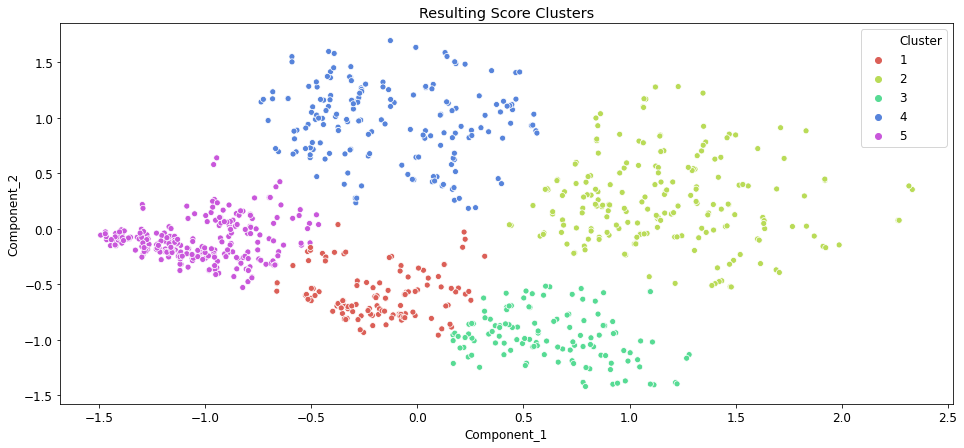

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,cluster,Death,Rehosp,Readmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,1,1,1,0
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,1,1,1,0
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,3,0,1,0
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,3,0,1,0
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,3,1,1,0
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,4,0,0,0
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,4,0,0,0


In [22]:
allDataDF, descSummary = runClustering(clusterModel=clusterModel, data=data, origData=escapeAllData, labels=escapeLabels, 
                                    modelName=allDataModelName, columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [23]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [1, 3, 2, 0, 4]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.210084,2,0.546218,2,0.142857,1,1.666667
1,0.333333,4,0.686869,5,0.222222,5,4.666667
2,0.300000,3,0.566667,3,0.200000,3,3.000000
3,0.333333,5,0.632184,4,0.206897,4,4.333333
4,0.192157,1,0.450980,1,0.152941,2,1.333333


In [24]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[2, 5, 3, 4, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.210084,2,0.546218,2,0.142857,1,1.666667,2
1,0.333333,4,0.686869,5,0.222222,5,4.666667,5
2,0.300000,3,0.566667,3,0.200000,3,3.000000,3
3,0.333333,5,0.632184,4,0.206897,4,4.333333,4
4,0.192157,1,0.450980,1,0.152941,2,1.333333,1


In [25]:
allDataDF = saveClusteredData(allDataDF, scoreAsmts,"Data/Preprocessed Data/ESCAPE_AC_AllData.csv")
allDataDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
DEIDNUM,,,,,,,,,,,,,,,,,,,,,
72,88.0,2.0,1.0,57.100000,26.424175,9.0,16.0,4.0,76.0,1.0,...,104.0,12.452563,139.333333,26.0,0.276596,0.250000,5,4,5,5
72,88.0,2.0,1.0,52.000000,24.064047,9.0,16.0,3.0,76.0,1.0,...,92.0,12.452563,126.000000,26.0,0.302326,0.282609,5,4,5,5
81,69.0,1.0,1.0,102.363636,32.307675,5.0,13.0,4.0,21.0,1.0,...,70.0,-3.346568,125.333333,32.0,0.363636,0.457143,4,5,4,4
81,69.0,1.0,1.0,100.454545,31.705134,5.0,13.0,2.0,21.0,1.0,...,72.0,-3.346568,105.666667,34.0,0.441558,0.472222,4,5,4,4
86,56.0,2.0,2.0,98.636364,40.016375,3.0,3.0,4.0,NaN,0.0,...,86.0,5.478621,146.666667,30.0,0.300000,0.348837,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99302,41.0,1.0,2.0,97.400000,40.541103,21.0,21.0,NaN,79.0,0.0,...,75.0,25.535155,130.000000,55.0,0.550000,0.733333,4,5,4,4
99912,46.0,1.0,1.0,78.636364,25.677180,2.0,2.0,4.0,89.0,0.0,...,67.0,-13.911732,174.666667,38.0,0.316667,0.567164,1,1,1,2
99912,46.0,1.0,1.0,78.200000,25.534694,2.0,2.0,3.0,89.0,0.0,...,60.0,-13.911732,140.666667,24.0,0.255319,0.400000,1,1,1,2


# Cluster: ARIC Cohort All Data

In [26]:
# first - try other clustering methods
allD = copy.deepcopy(aricCohortAllData)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

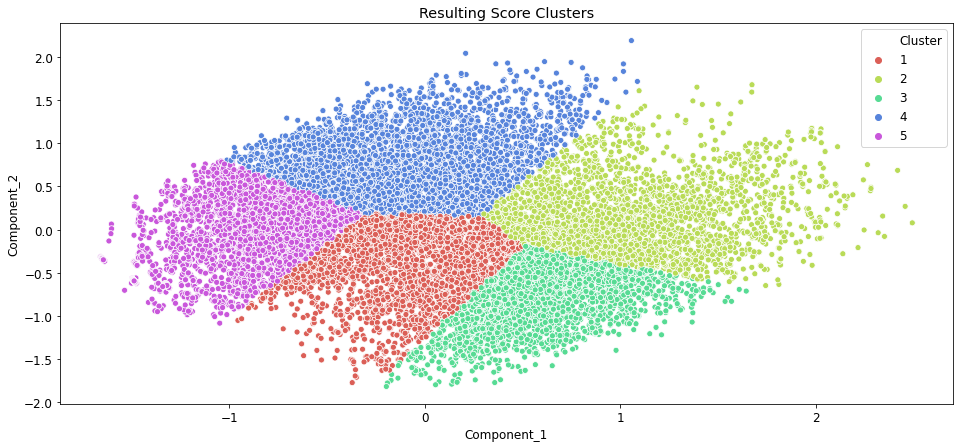

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,0.000000,0,11.0,NaN,0,0,...,0,0,252.666667,106.0,0.546392,1.492958,3,0,0,0
S105655,76,1,1,NaN,NaN,0,11.0,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,3,0,0,0
S105737,76,2,1,67.70,0.000000,0,3.0,NaN,0,1,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
S105737,76,2,1,63.30,28.185923,0,3.0,NaN,0,1,...,0,0,NaN,NaN,NaN,NaN,2,0,0,0
S106083,66,2,1,86.00,0.000000,0,10.0,0.0,0,0,...,0,0,188.666667,72.0,0.507042,0.734694,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,87.10,35.121038,0,3.0,NaN,0,1,...,0,0,NaN,NaN,NaN,NaN,1,0,0,0
S214752,80,2,1,66.90,0.000000,0,2.0,NaN,0,0,...,0,0,303.333333,120.0,0.521739,1.153846,4,0,0,0
S214752,80,2,1,67.10,24.616617,0,2.0,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,4,0,0,0


In [27]:
model = pickle.load(open('Score Label Preprocessing/ClusterModels/'+ allDataModelName + '.sav', 'rb'))

allDataDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=aricCohortAllData, labels=cohortLabels, 
                                    modelName='AricCohortAllData', columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [28]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [4, 2, 3, 0, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.086791,5,0.0,1,0.0,1,2.333333
1,0.037400,2,0.0,2,0.0,2,2.000000
2,0.079371,4,0.0,3,0.0,3,3.333333
3,0.037336,1,0.0,4,0.0,4,3.000000
4,0.070710,3,0.0,5,0.0,5,4.333333


In [29]:
print(finalScores)
scoreAsmts['FinalScores'] = scoreAsmts['DeathScores']
scoreAsmts

[2, 1, 4, 3, 5]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.086791,5,0.0,1,0.0,1,2.333333,5
1,0.037400,2,0.0,2,0.0,2,2.000000,2
2,0.079371,4,0.0,3,0.0,3,3.333333,4
3,0.037336,1,0.0,4,0.0,4,3.000000,1
4,0.070710,3,0.0,5,0.0,5,4.333333,3


In [30]:
allDataDF = saveClusteredData(allDataDF, scoreAsmts,"Data Validation/ARIC/Preprocessed Data/Aric_Cohort_AC_AllData.csv")
allDataDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
S105655,76,1,1,NaN,0.000000,0,11.0,NaN,0,0,...,0,0,252.666667,106.0,0.546392,1.492958,1,1,4,4
S105655,76,1,1,NaN,NaN,0,11.0,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,1,1,4,4
S105737,76,2,1,67.70,0.000000,0,3.0,NaN,0,1,...,0,0,NaN,NaN,NaN,NaN,5,5,1,1
S105737,76,2,1,63.30,28.185923,0,3.0,NaN,0,1,...,0,0,NaN,NaN,NaN,NaN,4,4,3,3
S106083,66,2,1,86.00,0.000000,0,10.0,0.0,0,0,...,0,0,188.666667,72.0,0.507042,0.734694,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S214744,74,2,1,87.10,35.121038,0,3.0,NaN,0,1,...,0,0,NaN,NaN,NaN,NaN,2,2,2,2
S214752,80,2,1,66.90,0.000000,0,2.0,NaN,0,0,...,0,0,303.333333,120.0,0.521739,1.153846,3,3,5,5
S214752,80,2,1,67.10,24.616617,0,2.0,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,3,3,5,5


# Cluster: ARIC Comm All Data

In [31]:
# first - try other clustering methods
allD = copy.deepcopy(aricCommAllData)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

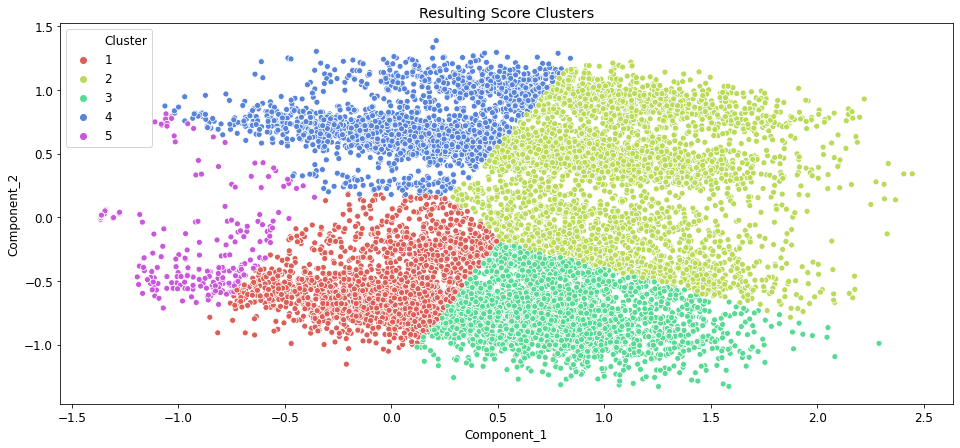

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,86.000,0.000000,0,10,0.0,0,0,...,0,0,188.666667,72.0,0.507042,0.734694,2,0,0,0
S106083,66,2,0,88.500,36.865164,0,10,0.0,0,0,...,0,0,176.000000,56.0,0.437500,0.571429,1,0,0,0
S106611,67,1,0,80.200,0.000000,0,5,4.0,0,0,...,0,0,248.666667,107.0,0.557292,1.445946,2,0,0,0
S106611,67,1,0,75.000,24.417188,0,5,4.0,0,0,...,0,0,196.000000,76.0,0.513514,1.027027,1,0,0,0
S106644,76,2,0,57.200,0.000000,0,5,0.0,0,1,...,0,0,206.333333,98.0,0.601227,1.126437,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,55.792,20.468112,0,5,NaN,0,1,...,0,0,185.000000,60.0,0.444444,0.937500,3,0,0,0
S210906,82,2,0,NaN,0.000000,0,3,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,4,0,0,0
S210906,82,2,0,NaN,NaN,0,3,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,4,0,0,0


In [32]:
model = pickle.load(open('Score Label Preprocessing/ClusterModels/'+ allDataModelName + '.sav', 'rb'))

allDataDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=aricCommAllData, labels=commLabels, 
                                    modelName='AricCommAllData', columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [33]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [3, 4, 2, 0, 1]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.005020,4,0.0,1,0.0,1,2.000000
1,0.002924,2,0.0,2,0.0,2,2.000000
2,0.004159,3,0.0,3,0.0,3,3.000000
3,0.011212,5,0.0,4,0.0,4,4.333333
4,0.001574,1,0.0,5,0.0,5,3.666667


In [34]:
print(finalScores)
scoreAsmts['FinalScores'] = scoreAsmts['DeathScores']
scoreAsmts

[2, 1, 3, 5, 4]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.005020,4,0.0,1,0.0,1,2.000000,4
1,0.002924,2,0.0,2,0.0,2,2.000000,2
2,0.004159,3,0.0,3,0.0,3,3.000000,3
3,0.011212,5,0.0,4,0.0,4,4.333333,5
4,0.001574,1,0.0,5,0.0,5,3.666667,1


In [35]:
allDataDF = saveClusteredData(allDataDF, scoreAsmts,"Data Validation/ARIC/Preprocessed Data/Aric_Comm_AC_AllData.csv")
allDataDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
S106083,66,2,0,86.000,0.000000,0,10,0.0,0,0,...,0,0,188.666667,72.0,0.507042,0.734694,3,3,3,3
S106083,66,2,0,88.500,36.865164,0,10,0.0,0,0,...,0,0,176.000000,56.0,0.437500,0.571429,2,2,2,2
S106611,67,1,0,80.200,0.000000,0,5,4.0,0,0,...,0,0,248.666667,107.0,0.557292,1.445946,3,3,3,3
S106611,67,1,0,75.000,24.417188,0,5,4.0,0,0,...,0,0,196.000000,76.0,0.513514,1.027027,2,2,2,2
S106644,76,2,0,57.200,0.000000,0,5,0.0,0,1,...,0,0,206.333333,98.0,0.601227,1.126437,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S210889,80,2,0,55.792,20.468112,0,5,NaN,0,1,...,0,0,185.000000,60.0,0.444444,0.937500,5,5,4,4
S210906,82,2,0,NaN,0.000000,0,3,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,1,1,5,5
S210906,82,2,0,NaN,NaN,0,3,NaN,0,0,...,0,0,NaN,NaN,NaN,NaN,1,1,5,5


# Cluster: GUIDE-IT All Data

In [36]:
# first - try other clustering methods
allD = copy.deepcopy(guideAllData)
allData = allD.replace(np.inf, 0)
allData = allData.fillna(0)

if pcaFlag:
    scaler = MinMaxScaler()#scale data
    allData.loc[:,:] = scaler.fit_transform(allData)
    pca = PCA(n_components=2)
    data = pca.fit_transform(allData)
else:
    data=allData

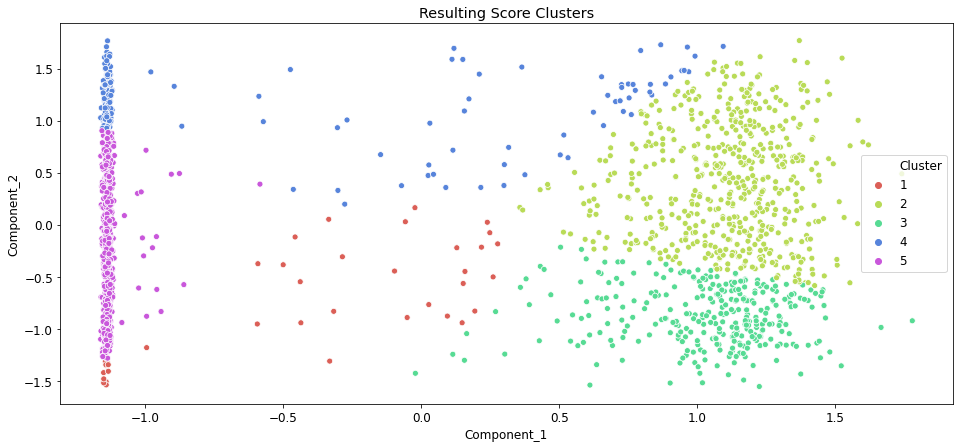

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,cluster,Death,Rehosp,Readmission
ID,,,,,,,,,,,,,,,,,,,,,
11,57.0,2.0,2.0,88.905017,33.643189,0,70.0,3.0,0,0.0,...,0,0,148.000000,33.0,0.323529,0.375000,1,0,1,0
11,57.0,2.0,2.0,91.172066,0.000000,0,70.0,3.0,0,0.0,...,0,0,147.000000,32.0,0.316832,0.363636,0,0,1,0
350,58.0,1.0,2.0,128.300000,39.449435,0,0.0,2.0,0,1.0,...,0,0,221.666667,45.0,0.298013,0.548780,1,0,0,0
350,58.0,1.0,2.0,NaN,0.000000,0,0.0,NaN,0,1.0,...,0,0,NaN,NaN,NaN,NaN,4,0,0,0
498,72.0,2.0,1.0,90.719405,24.998186,0,0.0,2.0,0,0.0,...,0,0,159.666667,48.0,0.417391,0.666667,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99676,74.0,1.0,2.0,NaN,0.000000,0,0.0,NaN,0,0.0,...,0,0,NaN,NaN,NaN,NaN,4,0,0,0
99887,60.0,2.0,2.0,76.204300,24.105394,0,0.0,1.0,0,0.0,...,0,0,190.666667,44.0,0.333333,0.463158,1,0,0,0
99887,60.0,2.0,2.0,NaN,0.000000,0,0.0,NaN,0,0.0,...,0,0,NaN,NaN,NaN,NaN,4,0,0,0


In [37]:
model = pickle.load(open('Score Label Preprocessing/ClusterModels/'+ allDataModelName + '.sav', 'rb'))

allDataDF, descSummary = runValidationClustering(clusterModel=model, data=data, origData=guideAllData, labels=guideLabels, 
                                    modelName='GuideAllData', columns=['MPAP', 'BPDIAS'], pca=pcaFlag)
allDataDF

In [38]:
scoreAsmts, finalScores = assignScoresFromClusters(descSummary)
scoreAsmts

rank index [3, 1, 4, 0, 2]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores
0,0.119048,2,0.404762,3,0.0,1,2.000000
1,0.214801,4,0.458484,4,0.0,2,3.333333
2,0.084691,1,0.302932,1,0.0,3,1.666667
3,0.311558,5,0.517588,5,0.0,4,4.666667
4,0.142857,3,0.392128,2,0.0,5,3.333333


In [39]:
print(finalScores)
scoreAsmts['FinalScores'] = finalScores
scoreAsmts

[2, 4, 1, 5, 3]


,DeathMean,DeathScores,RehospMean,RehospScores,ReadmMean,ReadmScores,AveScores,FinalScores
0,0.119048,2,0.404762,3,0.0,1,2.000000,2
1,0.214801,4,0.458484,4,0.0,2,3.333333,4
2,0.084691,1,0.302932,1,0.0,3,1.666667,1
3,0.311558,5,0.517588,5,0.0,4,4.666667,5
4,0.142857,3,0.392128,2,0.0,5,3.333333,3


In [40]:
allDataDF = saveClusteredData(allDataDF, scoreAsmts,"Data Validation/GUIDE-IT/Preprocessed Data/Guide_AC_AllData.csv")
allDataDF

,Age,Gender,Race,Wt,BMI,InitialHospDays,TotalHospDays,NYHA,MLHFS,AF,...,HR,PV,MAP,PP,PPP,PPRatio,Score,ScoreDeath,ScoreRehosp,ScoreReadmission
ID,,,,,,,,,,,,,,,,,,,,,
11,57.0,2.0,2.0,88.905017,33.643189,0,70.0,3.0,0,0.0,...,0,0,148.000000,33.0,0.323529,0.375000,4,4,4,2
11,57.0,2.0,2.0,91.172066,0.000000,0,70.0,3.0,0,0.0,...,0,0,147.000000,32.0,0.316832,0.363636,2,2,3,1
350,58.0,1.0,2.0,128.300000,39.449435,0,0.0,2.0,0,1.0,...,0,0,221.666667,45.0,0.298013,0.548780,4,4,4,2
350,58.0,1.0,2.0,NaN,0.000000,0,0.0,NaN,0,1.0,...,0,0,NaN,NaN,NaN,NaN,3,3,2,5
498,72.0,2.0,1.0,90.719405,24.998186,0,0.0,2.0,0,0.0,...,0,0,159.666667,48.0,0.417391,0.666667,4,4,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99676,74.0,1.0,2.0,NaN,0.000000,0,0.0,NaN,0,0.0,...,0,0,NaN,NaN,NaN,NaN,3,3,2,5
99887,60.0,2.0,2.0,76.204300,24.105394,0,0.0,1.0,0,0.0,...,0,0,190.666667,44.0,0.333333,0.463158,4,4,4,2
99887,60.0,2.0,2.0,NaN,0.000000,0,0.0,NaN,0,0.0,...,0,0,NaN,NaN,NaN,NaN,3,3,2,5
